In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
from matplotlib import pyplot as plt
from cmocean import cm
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
# for heavy processing:
cluster = PBSCluster(cores=6, processes=6, walltime='02:00:00')
w = cluster.scale(2*10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [7]:
client

<Client: 'tcp://10.135.39.27:40726' processes=12 threads=12, memory=200.04 GB>

___________
# Useful info.

In [8]:
#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])

# coriolis term
lat = grd_rspec['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))

In [9]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 

_________________

## Part 1. global KE comparisons (among ageostrophic, geostrophic and total uv)

(lat,lon,KE)

In [10]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(work_data_dir+'xy/total_uv/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_total = xr.concat(D, dim='face')
E_total = ds_total.E_all
E_total_low = ds_total.E_low

D = [xr.open_zarr(work_data_dir+'xy/geo_uv/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_geo = xr.concat(D, dim='face')
E_geo = ds_geo.E_all

D = [xr.open_zarr(work_data_dir+'xy/Ageo_uv/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_ageo = xr.concat(D, dim='face')
E_ageo = ds_ageo.E_all
E_ageo_low = ds_ageo.E_low

In [11]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(work_data_dir+'xy/total_uv_all/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_total_all = xr.concat(D, dim='face')
E_total_all = ds_total_all.E_all
E_total_all_low = ds_total_all.E_low

D = [xr.open_zarr(work_data_dir+'xy/geo_uv_all/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_geo_all = xr.concat(D, dim='face')
E_geo_all = ds_geo_all.E_all

D = [xr.open_zarr(work_data_dir+'xy/Ageo_uv_all/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_ageo_all = xr.concat(D, dim='face')
E_ageo_all = ds_ageo_all.E_all
E_ageo_all_low = ds_ageo_all.E_low

In [15]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>=0) & (vplt.XC<=180.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where(vplt.XC<=0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            if face in [11,12]:
                # this deals with dateline crossing areas
                im = vplt.where(vplt.j!=40).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)       
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[-2, -1, 0, 1])
        cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$','10$^1$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

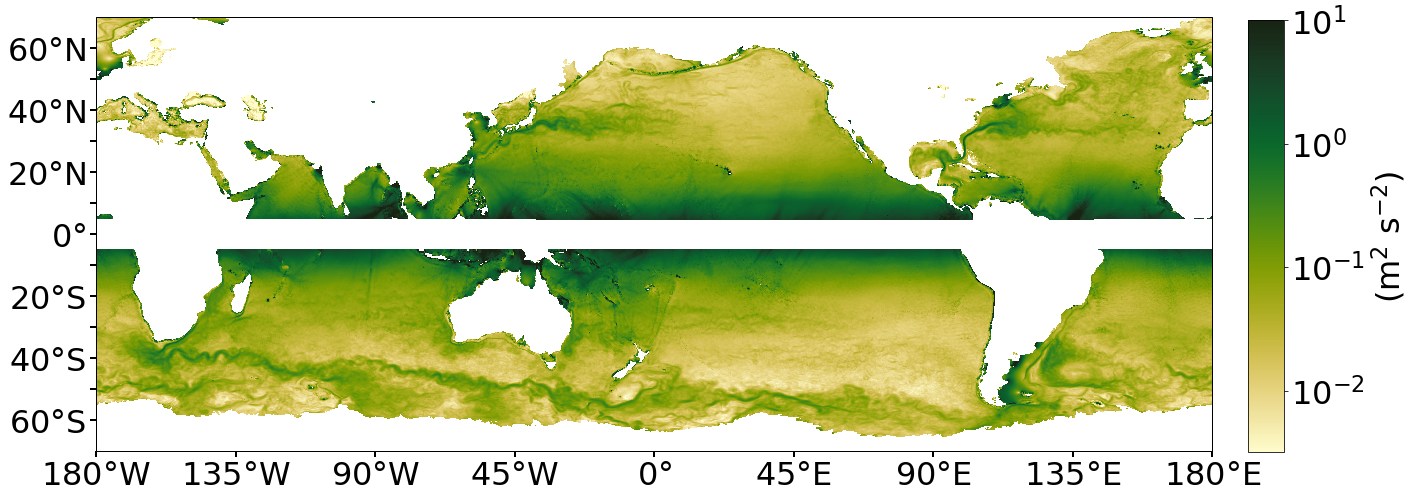

In [13]:
plot_pretty( np.log10(E_geo_all.isel(i=slice(1,-1),j=slice(1,-1))/2).where( (ice>0) & (np.abs(E_geo_all.YC)>5) ), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

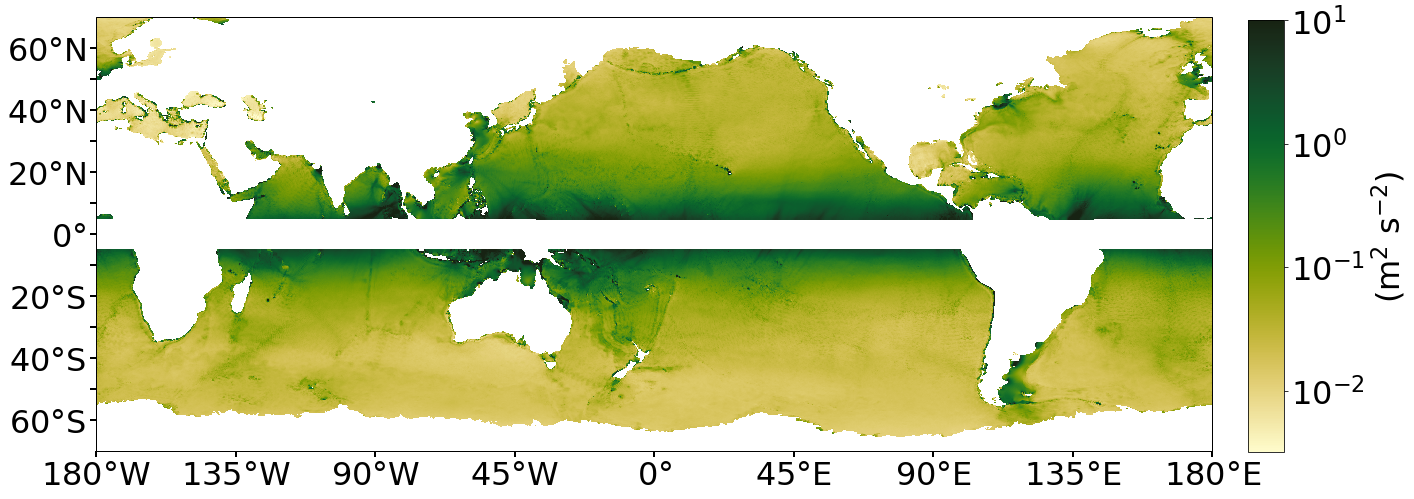

In [18]:
plot_pretty( np.log10(E_ageo_all.isel(i=slice(1,-1),j=slice(1,-1))/2).where( (ice>0) & (np.abs(E_geo_all.YC)>5) ), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

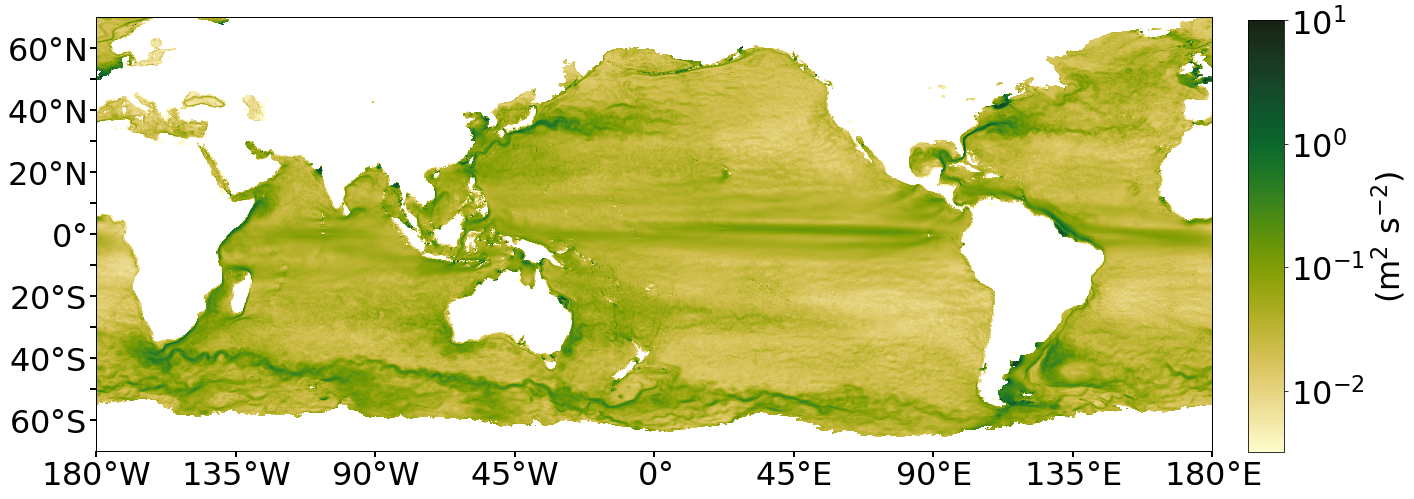

In [10]:
plot_pretty( np.log10(E_total_all.isel(i=slice(1,-1),j=slice(1,-1))/2).where(ice>0), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

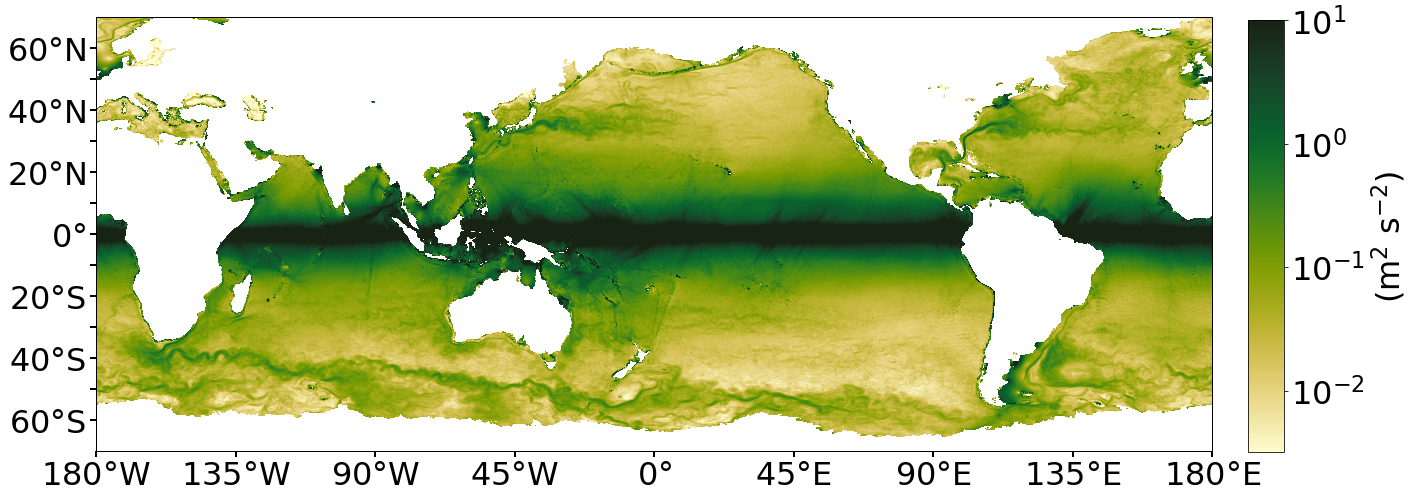

In [11]:
plot_pretty( np.log10(E_geo_all.isel(i=slice(1,-1),j=slice(1,-1))/2).where(ice>0), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

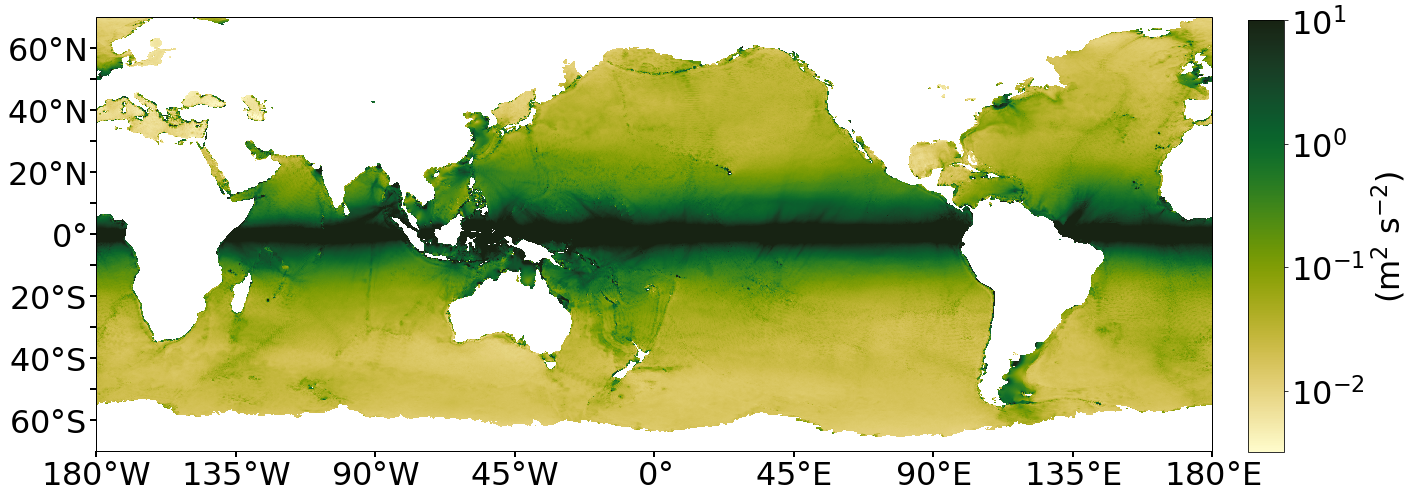

In [12]:
plot_pretty( np.log10(E_ageo_all.isel(i=slice(1,-1),j=slice(1,-1))/2).where(ice>0), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

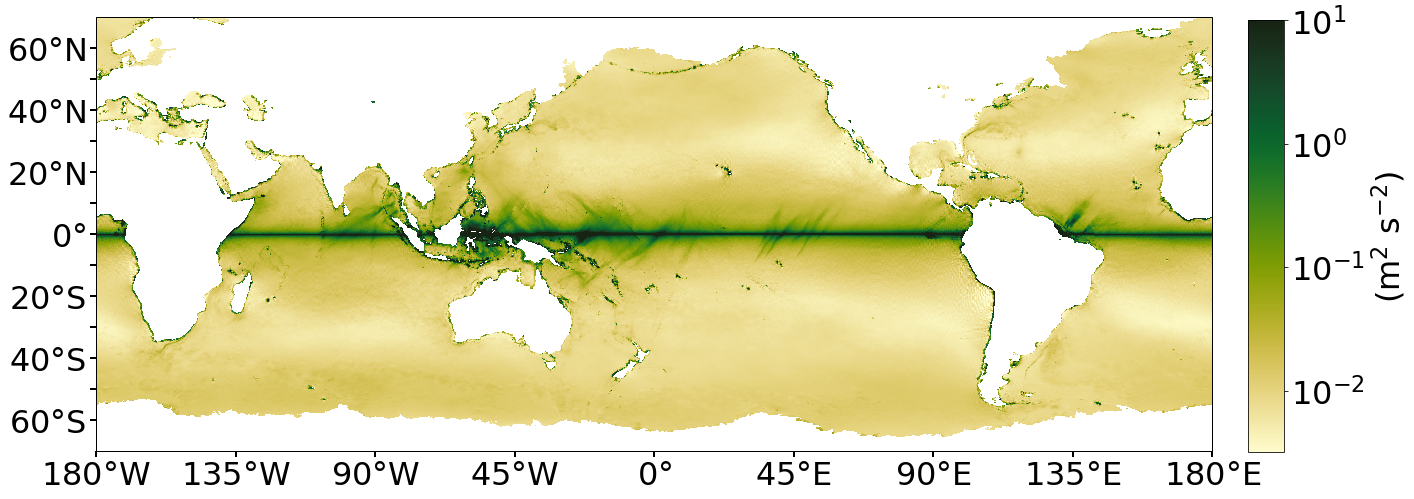

In [13]:
plot_pretty( np.log10(ds_ageo_all.E_low.isel(i=slice(1,-1),j=slice(1,-1))/2).where(ice>0), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

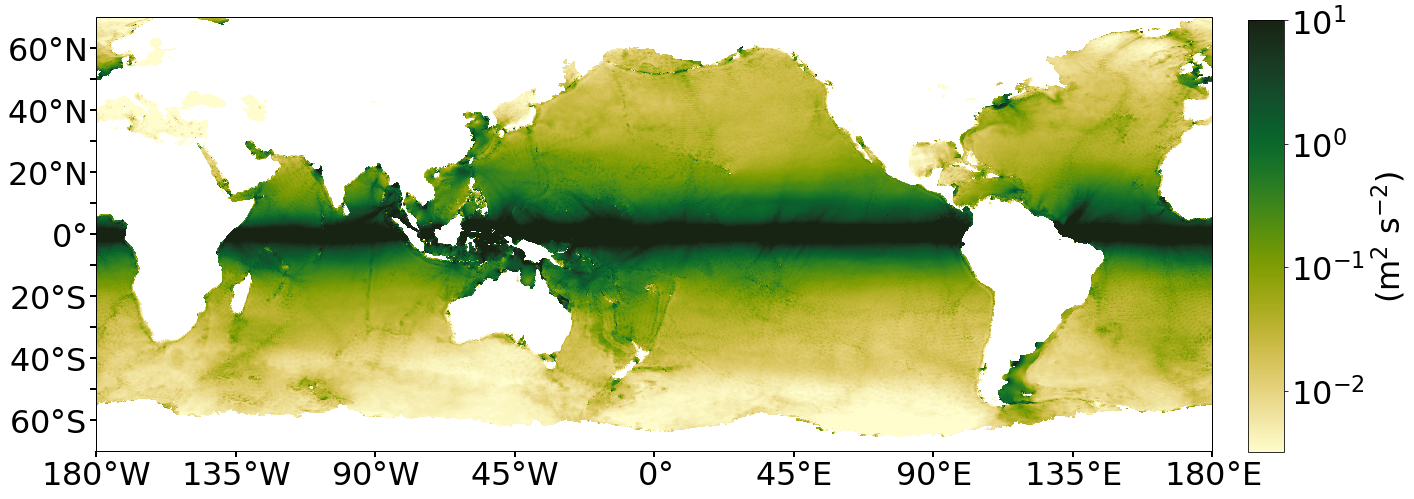

In [14]:
plot_pretty( np.log10(ds_ageo_all.E_high.isel(i=slice(1,-1),j=slice(1,-1))/2).where(ice>0), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

In [18]:
ds_geo_all

<xarray.Dataset>
Dimensions:    (face: 13, i: 1080, j: 1080)
Coordinates:
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxC        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxG        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyC        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyG        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_i        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_j        (face, j, i) float32 dask.arr

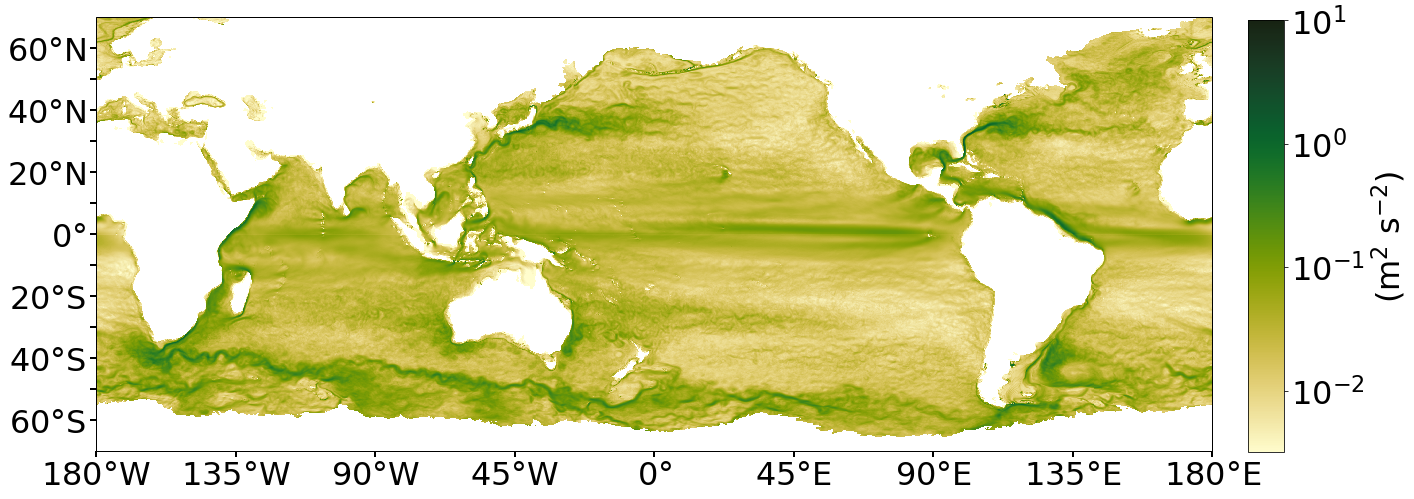

In [16]:
plot_pretty( np.log10(ds_total_all.E_low.isel(i=slice(1,-1),j=slice(1,-1))/2).where(ice>0), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

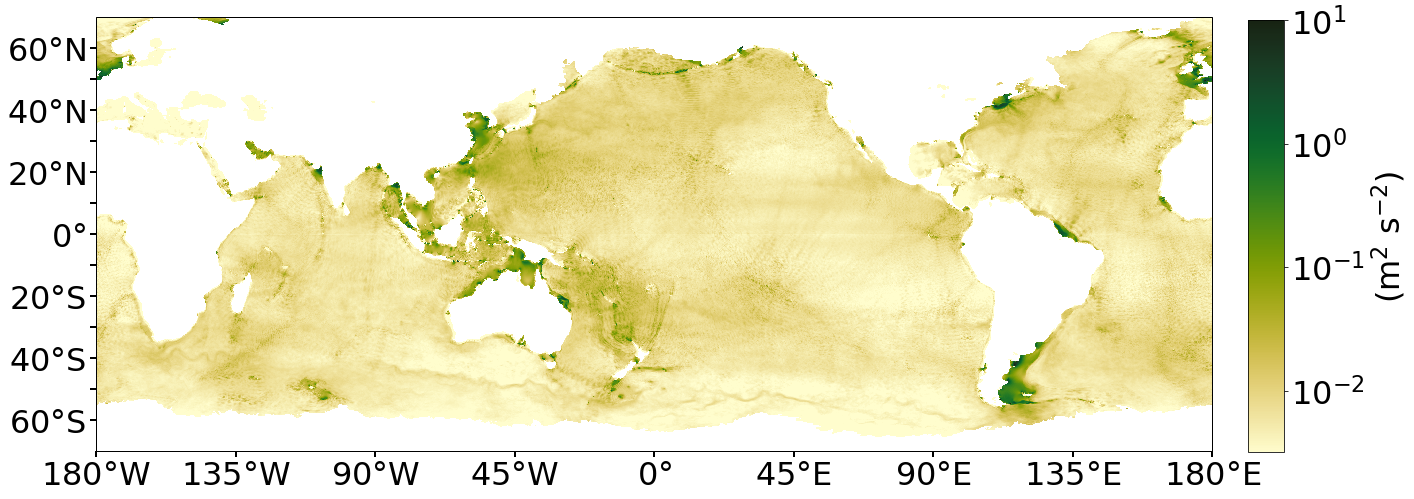

In [17]:
plot_pretty( np.log10(ds_total_all.E_high.isel(i=slice(1,-1),j=slice(1,-1))/2).where(ice>0), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

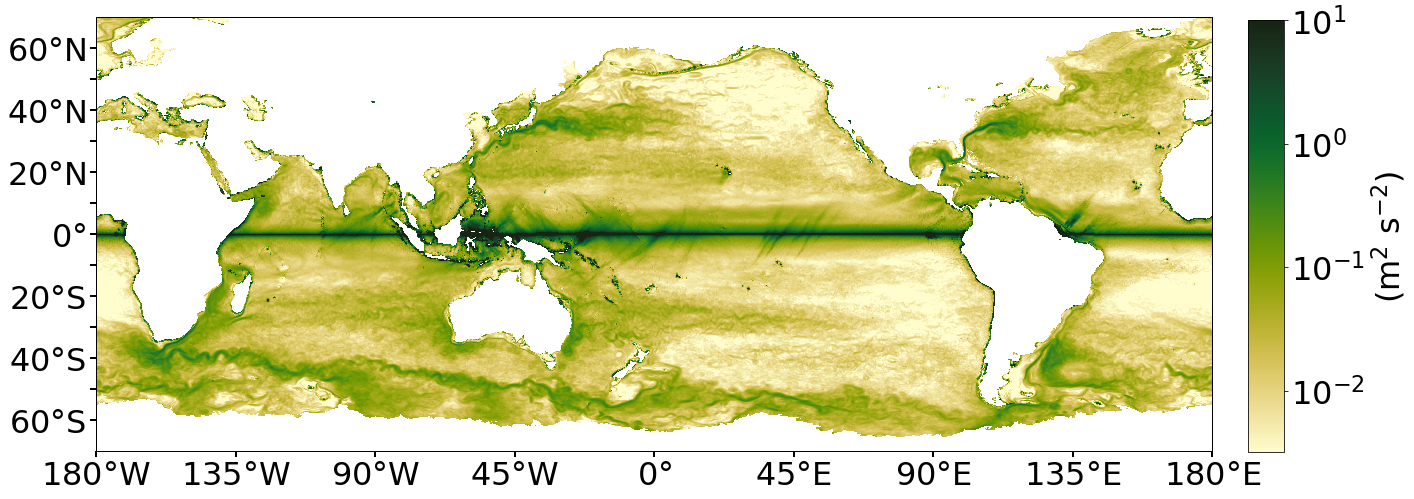

In [19]:
plot_pretty( np.log10(ds_geo_all.E_low.isel(i=slice(1,-1),j=slice(1,-1))/2).where(ice>0), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

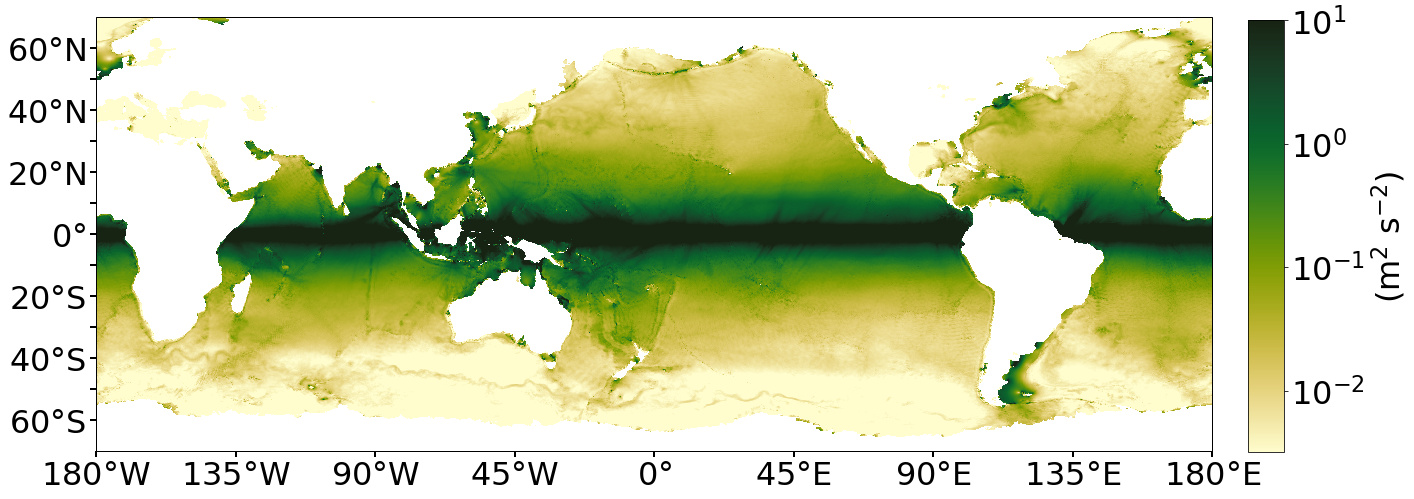

In [20]:
plot_pretty( np.log10(ds_geo_all.E_high.isel(i=slice(1,-1),j=slice(1,-1))/2).where(ice>0), label='(m$^2$ s$^{-2}$)', vmin=-2.5, vmax=1, cmmap='speed', ignore_face=[6])

______________
# Ratio

In [9]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='Greens_r',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
        #cmap = getattr(cm, cmmap)
        #cmap = cmmap
        cmmap=plt.cm.get_cmap('Greens_r', 5)
        cmap = cmmap
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>=0) & (vplt.XC<=180.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where(vplt.XC<=0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            if face in [11,12]:
                # this deals with dateline crossing areas
                im = vplt.where(vplt.j!=40).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)   
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
        #cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        #ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
        #ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

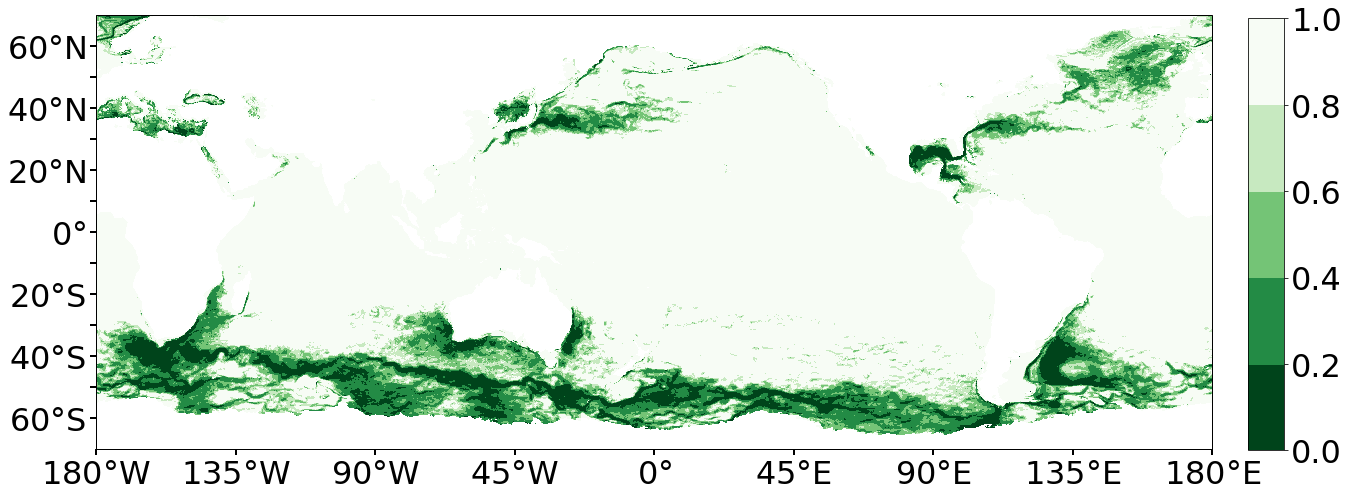

In [10]:
plot_pretty( (E_ageo_all.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)/E_total_all.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6])

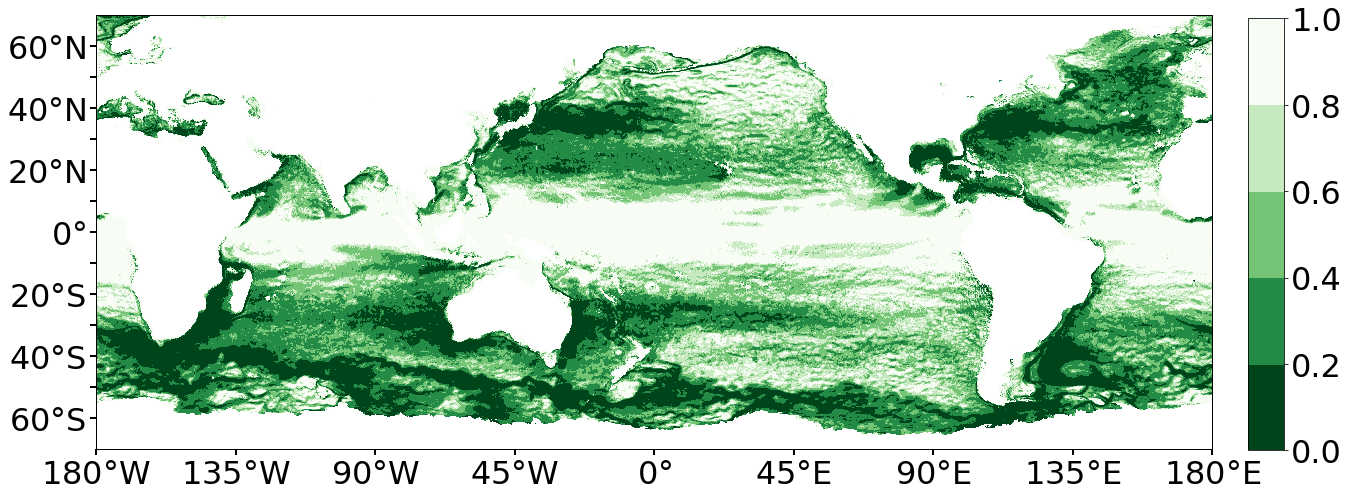

In [12]:
plot_pretty( (E_ageo_all_low.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)/E_total_all_low.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6])

Text(0.5, 0, '')

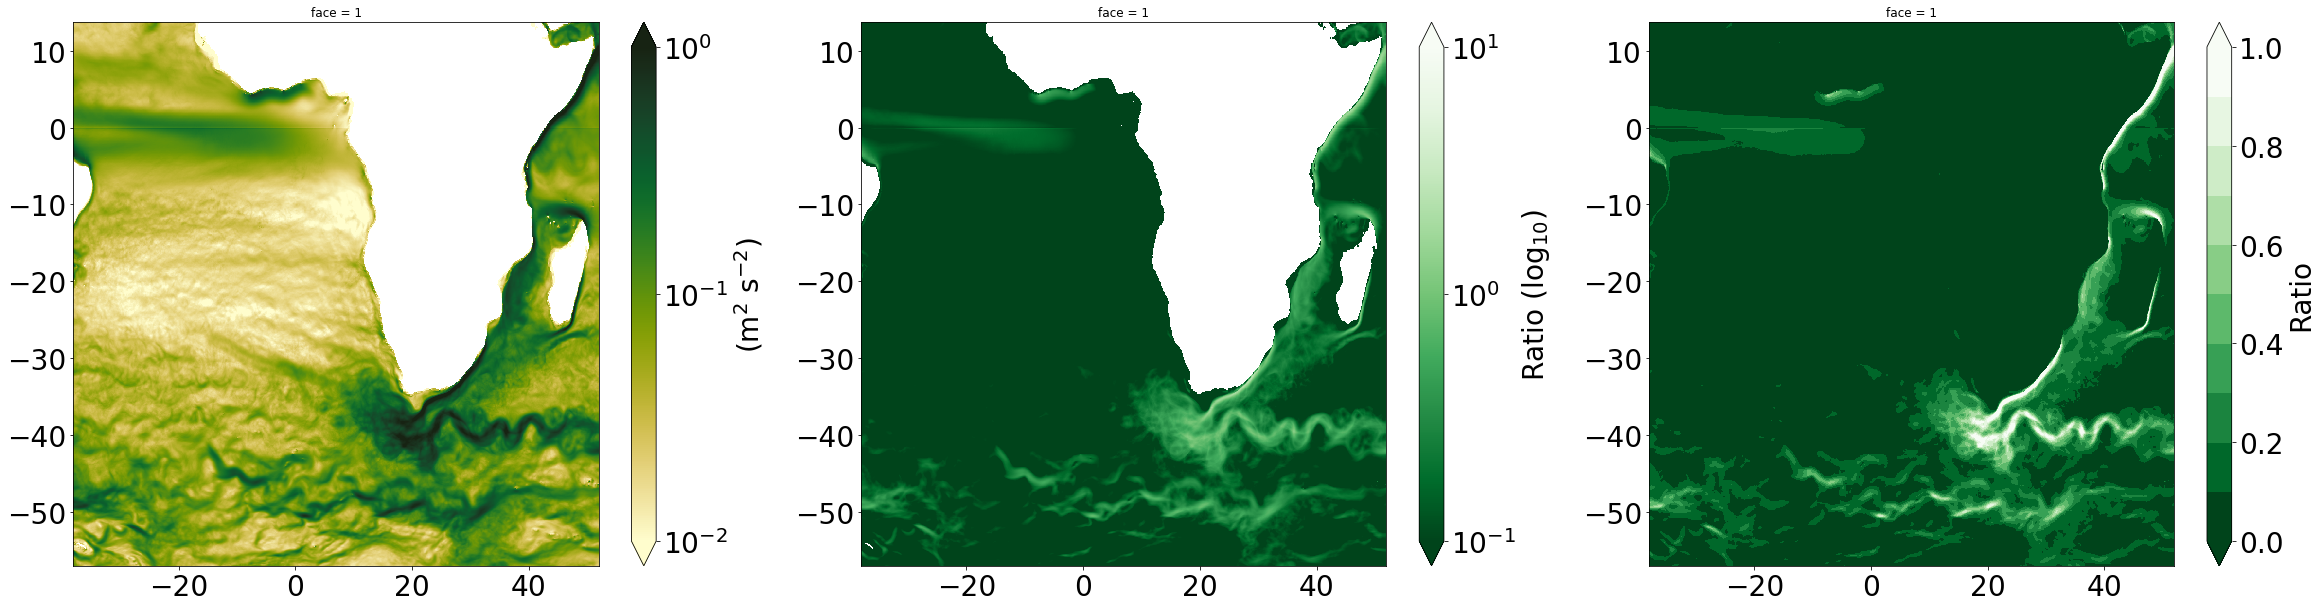

In [9]:
font_size =28
fig = plt.figure(figsize=(40,10))

ax = plt.subplot(131)
cax=np.log10(ds_total_all.E_low.isel(face=1)).plot(x='XC', y='YC',vmin= -2, vmax = 0, cmap=cm.speed, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical', ticks=[-2, -1, 0])
cbar.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(132)
cax=np.log10(ds_total_all.E_low.isel(face=1)).plot(x='XC', y='YC',vmin= -1, vmax = 1, cmap='Greens_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical', ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['10$^{-1}$','10$^0$','10$^1$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio (log$_{10}$)', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(133)
cax=(ds_total_all.E_low.isel(face=1)).plot(x='XC', y='YC',vmin= 0, vmax = 1, cmap=plt.cm.get_cmap('Greens_r', 10), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

In [22]:
cluster.close()